In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler

In [19]:
# discount factor for rewards
GAMMA = 0.99
# weight update learning rate
ALPHA = 0.1

In [20]:
def epsilon_greedy(model, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    values = model.predict_all_actions(s)
    return np.argmax(values)
  else:
    return model.env.action_space.sample()

In [21]:
def gather_samples(env, n_episodes=10000):
  samples = []
  for _ in range(n_episodes):
    s, info = env.reset()
    done = False
    truncated = False
    while not (done or truncated):
      a = env.action_space.sample()
      sa = np.concatenate((s, [a]))
      samples.append(sa)

      s, r, done, truncated, info = env.step(a)
  return samples

In [22]:
class Model:
  def __init__(self, env):
    # fit the featurizer to data
    self.env = env
    samples = gather_samples(env)
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x @ self.w

  def predict_all_actions(self, s):
    return [self.predict(s, a) for a in range(self.env.action_space.n)]

  def grad(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x


In [23]:
def test_agent(model, env, n_episodes=20):
  reward_per_episode = np.zeros(n_episodes)
  for it in range(n_episodes):
    done = False
    truncated = False
    episode_reward = 0
    s, info = env.reset()
    while not (done or truncated):
      a = epsilon_greedy(model, s, eps=0)
      s, r, done, truncated, info = env.step(a)
      episode_reward += r
    reward_per_episode[it] = episode_reward
  return np.mean(reward_per_episode)

In [24]:
def watch_agent(model, env, eps):
  done = False
  truncated = False
  episode_reward = 0
  s, info = env.reset()
  while not (done or truncated):
    a = epsilon_greedy(model, s, eps=eps)
    s, r, done, truncated, info = env.step(a)
    episode_reward += r
  print("Episode reward:", episode_reward)

In [25]:
# instantiate environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [26]:
model = Model(env)
reward_per_episode = []

/Users/vn55kbe/Library/Caches/pypoetry/virtualenvs/udemy-rl-lazyprog-mg6LNPs4-py3.11/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [27]:
# watch untrained agent
watch_agent(model, env, eps=0)

Episode reward: 9.0


In [28]:
# repeat until convergence
n_episodes = 1500
for it in range(n_episodes):
    s, info = env.reset()
    episode_reward = 0
    done = False
    truncated = False
    while not (done or truncated):
        a = epsilon_greedy(model, s)
        s2, r, done, truncated, info = env.step(a)

        # get the target
        if done:
            target = r
        else:
            values = model.predict_all_actions(s2)
            target = r + GAMMA * np.max(values)

        # update the model
        g = model.grad(s, a)
        err = target - model.predict(s, a)
        model.w += ALPHA * err * g

        # accumulate reward
        episode_reward += r

        # update state
        s = s2

    if (it + 1) % 50 == 0:
        print(f"Episode: {it + 1}, Reward: {episode_reward}")

    # early exit
    if it > 20 and np.mean(reward_per_episode[-20:]) == 200:
        print("Early exit")
        break

    reward_per_episode.append(episode_reward)

Episode: 50, Reward: 17.0
Episode: 100, Reward: 22.0
Episode: 150, Reward: 50.0
Episode: 200, Reward: 58.0
Episode: 250, Reward: 69.0
Episode: 300, Reward: 76.0
Episode: 350, Reward: 197.0
Episode: 400, Reward: 92.0
Episode: 450, Reward: 137.0
Episode: 500, Reward: 165.0
Episode: 550, Reward: 102.0
Episode: 600, Reward: 131.0
Episode: 650, Reward: 154.0
Episode: 700, Reward: 173.0
Episode: 750, Reward: 399.0
Episode: 800, Reward: 67.0
Episode: 850, Reward: 166.0
Episode: 900, Reward: 154.0
Episode: 950, Reward: 266.0
Episode: 1000, Reward: 49.0
Episode: 1050, Reward: 121.0
Episode: 1100, Reward: 216.0
Episode: 1150, Reward: 136.0
Episode: 1200, Reward: 198.0
Episode: 1250, Reward: 370.0
Episode: 1300, Reward: 282.0
Episode: 1350, Reward: 223.0
Episode: 1400, Reward: 191.0
Episode: 1450, Reward: 356.0
Episode: 1500, Reward: 500.0


In [29]:
# test trained agent
test_reward = test_agent(model, env)
print(f"Average test reward: {test_reward}")

Average test reward: 500.0


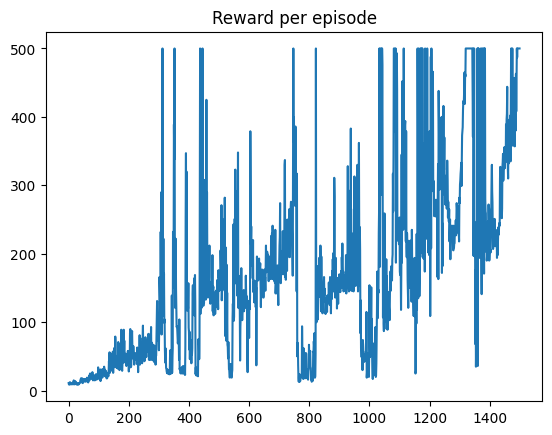

In [30]:
plt.plot(reward_per_episode)
plt.title("Reward per episode")
plt.show()

In [31]:
# watch trained agent

# this may freeze your computer

#env = gym.make("CartPole-v1", render_mode="human")
#watch_agent(model, env, eps=0)

/Users/vn55kbe/Library/Caches/pypoetry/virtualenvs/udemy-rl-lazyprog-mg6LNPs4-py3.11/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode reward: 500.0
